In [ ]:
!pip install tensorflow

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import zipfile
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_class_weight


#Data Extraction


##Feature Extraction and Data Augmentation
In the below section, I defined Python functions that process the audio files and extract meaningful features required for emotion classification.

###Summary of Each Function:

- `emotion_map`: A dictionary to map emotion codes as number (like '01', '02') to actual emotions (like 'neutral', 'calm') as given in the dataset format in the dataset website.

- `summarize_feature(feature)`: This function takes a 2D feature matrix (like MFCC) and summarizes it using mean, std, min, and max across time frames. This helped in reduce the dimensionality while keeping important statistical information.

- `augment_audio(audio, sr)`: This function creates multiple augmented versions of the original audio using:
  - Pitch shifting
  - Time stretching
  - Adding noise  
  This helped in improving model generalization and makes the model more robust to variations in audio.

- `features_extract(path_of_files, augment_for_training=False)`: Given a `.wav` file path, this function:
  - Loads the audio using Librosa
  - Optionally applies random augmentation if `augment_for_training=True`
  - Extracts features such as:
    - MFCC, delta, delta-delta
    - Chroma, contrast, mel-spectrogram
    - Tonnetz, zero crossing rate (ZCR), and root mean square (RMS)
  - Combines and summarizes all the above features into one feature vector which is a 1D array

- `complete_all_actors(base_dir, augment_training_data=False)`: Iterates over all `.wav` files from each actor’s folder inside the dataset directory, extracts features using `features_extract()`, and returns a list of `[features, label]` pairs.
  - If `augment_training_data=True`, it will extract and store both original and one randomly augmented version for each file.

##Test data is not Augmented:
Feature Extraction (complete_all_actors) - This function only augments a sample (i.e., applies noise/pitch/time-stretch) if augment_training_data=True is passed.
When I call complete_all_actors("Audio_Song_Actors_01-24") and complete_all_actors("Audio_Speech_Actors_01-24"), I do NOT specify augment_training_data=True, so no augmentation is performed at this stage.



In [ ]:
emotion_map = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

def summarize_feature(feature):
    return np.hstack([
        np.mean(feature.T, axis=0),
        np.std(feature.T, axis=0),
        np.min(feature.T, axis=0),
        np.max(feature.T, axis=0)
    ])

def augment_audio(audio, sr):
    augmented_versions = []

    # pitch shift
    audio_pitch = librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=random.choice([-2, 2])) # Randomize pitch shift steps
    augmented_versions.append(audio_pitch)

    # time stretch
    audio_stretch = librosa.effects.time_stretch(y=audio, rate=random.choice([0.8, 1.2])) # Randomize time stretch rate
    augmented_versions.append(audio_stretch)

    # adding noise
    noise_factor = random.uniform(0.003, 0.008) # Randomize noise factor
    noise = noise_factor * np.random.randn(len(audio))
    audio_noise = audio + noise
    augmented_versions.append(audio_noise)

    return augmented_versions


def features_extract(path_of_files, augment_for_training=False):
  try:
    audio, sr = librosa.load(path_of_files, sr=22050, res_type='scipy')

    #applying one random augmentation feature extraction
    if augment_for_training:
        #get all augmented versions
        augmented_audios = augment_audio(audio, sr)
        #randomly choose one augmented version to extract features from
        audio = random.choice(augmented_audios)

    stft = np.abs(librosa.stft(audio))

    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
    mfccs_delta = librosa.feature.delta(mfccs)
    mfccs_delta2 = librosa.feature.delta(mfccs, order=2)
    chroma = librosa.feature.chroma_stft(S=stft, sr=sr)
    contrast = librosa.feature.spectral_contrast(S=stft, sr=sr)
    mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)

    if mfccs.shape[1] == 0 or chroma.shape[1] == 0 or contrast.shape[1] == 0 or mel.shape[1] == 0:
        return None  # skip bad files

    mfccs_features = np.vstack([mfccs, mfccs_delta, mfccs_delta2])
    mfccs_features = summarize_feature(mfccs_features)
    chroma = summarize_feature(chroma)
    contrast = summarize_feature(contrast)
    mel = summarize_feature(mel)

    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sr)
    tonnetz = summarize_feature(tonnetz)

    zcr = summarize_feature(librosa.feature.zero_crossing_rate(y=audio))
    rms = summarize_feature(librosa.feature.rms(y=audio))

    return np.hstack([mfccs_features, chroma, contrast, mel, tonnetz, zcr, rms])
  except Exception as e:
    print(f"Error in processing of file {path_of_files} : {e}")

def complete_all_actors(base_dir, augment_training_data=False):
  features = []
  for actor_folder in os.listdir(base_dir):
    actor_path = os.path.join(base_dir, actor_folder)
    if os.path.isdir(actor_path):
      for file in os.listdir(actor_path):
        if file.endswith(".wav"):
          file_path = os.path.join(actor_path, file)
          emotion_code = file.split("-")[2]
          label = emotion_map.get(emotion_code)
          if label:
            #process the original (non-augmented) version
            feat_original = features_extract(file_path, augment_for_training=False)
            if feat_original is not None:
              features.append([feat_original, label])

            #if augment_training_data is True, also add an augmented version for training
            if augment_training_data:
                feat_augmented = features_extract(file_path, augment_for_training=True)
                if feat_augmented is not None:
                    features.append([feat_augmented, label])
  return features

##Dataset Loading, Feature Extraction & DataFrame Preparation

This block performs the following steps:

1. **Extract Dataset Archives**  
   I first check if the extracted folders for both *song* and *speech* datasets exist. If not, I unzip them from `.zip` files to access all `.wav` files for each actor.

2. **Feature Extraction from All Files**  
   Then call `complete_all_actors()` on both the **song** and **speech** folders to extract features for all audio files. The result is a list of `[features, label]` pairs.

3. **Combine the Data**  
   Then I am going to combine the features from both song and speech data into a single dataset (`combined_data`).

4. **Create a Pandas DataFrame**  
   Then I can convert the list of `[features, label]` into a structured Pandas DataFrame with two columns:
   - `'features'` → contains the feature vector (NumPy array)
   - `'label'` → contains the corresponding emotion label

5. **Saving for Future Use**  
   I also save the DataFrame using `to_pickle()` so that I don’t have to re-extract features every time I run the notebook.

6. **Showing Dataset Summary**  
   Finally, I print a summary of:
   - Total number of samples
   - Length of feature vectors
   - Label (emotion) distribution
   - First few rows of the DataFrame


In [ ]:
zip_file_path_song = "./Audio_Song_Actors_01-24.zip"
extracted_dir_song = "Audio_Song_Actors_01-24"

if not os.path.exists(extracted_dir_song):
    print(f"Extracting {zip_file_path_song} to {extracted_dir_song}...")
    with zipfile.ZipFile(zip_file_path_song, 'r') as zip_ref:
        zip_ref.extractall("./Audio_Song_Actors_01-24")
    print("Extraction complete.")
else:
    print(f"Directory '{extracted_dir_song}' already exists. Skipping extraction.")

zip_file_path_speech = "./Audio_Speech_Actors_01-24.zip"
extracted_dir_speech = "Audio_Speech_Actors_01-24"

if not os.path.exists(extracted_dir_speech):
    print(f"Extracting {zip_file_path_speech} to {extracted_dir_speech}...")
    with zipfile.ZipFile(zip_file_path_speech, 'r') as zip_ref:
        zip_ref.extractall(extracted_dir_speech)
    print("Extraction complete.")
else:
    print(f"Directory '{extracted_dir_speech}' already exists. Skipping extraction.")

data_song = complete_all_actors("Audio_Song_Actors_01-24")
data_speech = complete_all_actors("Audio_Speech_Actors_01-24")

combined_data = data_song + data_speech

df = pd.DataFrame(combined_data, columns=['features', 'label'])

print(f"\nDataset Summary:")
print(f"Total samples: {len(df)}")
if len(df) > 0:
    print(f"Feature vector length: {len(df['features'].iloc[0])}")
    print(f"\nLabel distribution:")
    print(df['label'].value_counts())
    print(f"\nFirst 5 samples:")
    print(df.head())
else:
    print("No data was successfully processed!")

df.to_pickle("processed_audio_features.pkl")

df.head()

Directory 'Audio_Song_Actors_01-24' already exists. Skipping extraction.
Directory 'Audio_Speech_Actors_01-24' already exists. Skipping extraction.


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=1012
  warnings.warn(



Dataset Summary:
Total samples: 2452
Feature vector length: 860

Label distribution:
label
fearful      376
calm         376
angry        376
sad          376
happy        376
disgust      192
surprised    192
neutral      188
Name: count, dtype: int64

First 5 samples:
                                            features    label
0  [-524.6265869140625, 27.61652183532715, -21.23...  fearful
1  [-649.654296875, 30.94328498840332, -15.079976...     calm
2  [-649.4614868164062, 23.35599136352539, -11.13...     calm
3  [-626.99462890625, 26.342117309570312, -18.635...  neutral
4  [-430.5823974609375, 30.375041961669922, -35.5...    angry


,features,label
0,"[-524.6265869140625, 27.61652183532715, -21.23...",fearful
1,"[-649.654296875, 30.94328498840332, -15.079976...",calm
2,"[-649.4614868164062, 23.35599136352539, -11.13...",calm
3,"[-626.99462890625, 26.342117309570312, -18.635...",neutral
4,"[-430.5823974609375, 30.375041961669922, -35.5...",angry


#**Data** **Preprocessing**

##Dataset Balancing

Before training our emotion classification model, I think it is very important to check whether the dataset is **balanced** ,i.e. , all emotion classes should have approximately the same number of samples. If some classes dominate the dataset, the model may become biased and fail to learn minority emotions properly..

###Step 1: Checking the Initial Distribution

First I am going to load the `processed_audio_features.pkl` file and visualize the number of samples for each emotion using a **bar plot**. Also going to print the percentage distribution of each class.



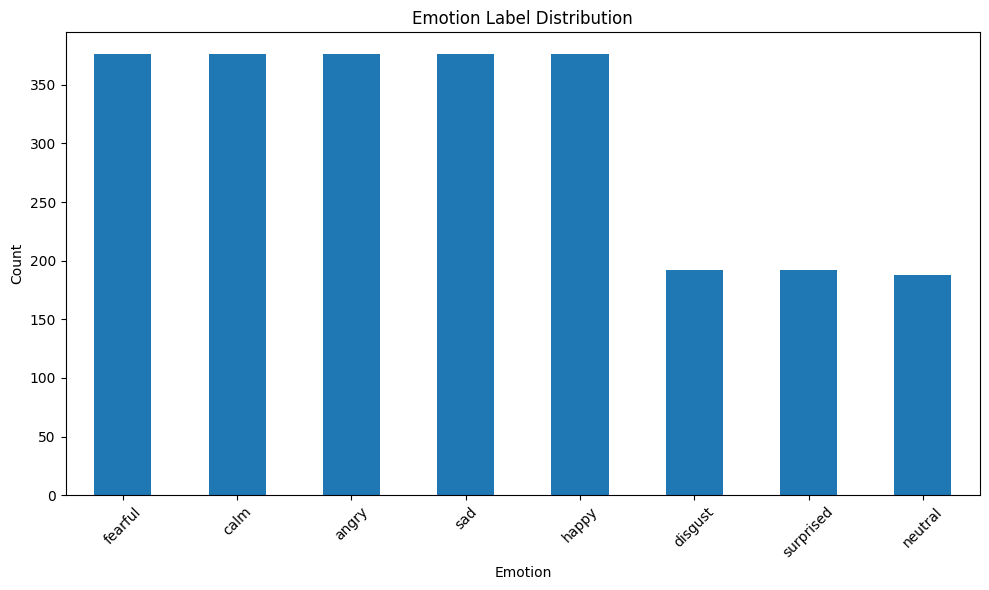


Percentage Distribution:
label
fearful      15.33
calm         15.33
angry        15.33
sad          15.33
happy        15.33
disgust       7.83
surprised     7.83
neutral       7.67
Name: proportion, dtype: float64


In [ ]:

df = pd.read_pickle("processed_audio_features.pkl")

plt.figure(figsize=(10, 6))
df['label'].value_counts().plot(kind='bar')
plt.title('Emotion Label Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nPercentage Distribution:")
print((df['label'].value_counts(normalize=True) * 100).round(2))

####**From the output, we observed some imbalance , clearly, disgust, surprised, and neutral are under represented.**


###Step 2: Fixing the Imbalance

To solve this, I used **up-sampling**. The `balance_dataframe(df)` function:
- Splits the DataFrame into separate mini-dataframes for each emotion
- Finds the class with the **maximum number of samples**
- Resamples (with replacement) the other classes to match this count
- Combines and shuffles everything back into a new balanced DataFrame

We then save this balanced dataset back into the same `.pkl` file to ensure all steps down the way use the updated data.




In [ ]:
from sklearn.utils import resample

def balance_dataframe(df):
    dfs = [df[df['label'] == emotion] for emotion in df['label'].unique()]
    max_count = max(len(sub_df) for sub_df in dfs)

    dfs_balanced = [
        resample(sub_df, replace=True, n_samples=max_count, random_state=42)
        for sub_df in dfs
    ]

    df_balanced = pd.concat(dfs_balanced).sample(frac=1, random_state=42).reset_index(drop=True)
    return df_balanced

df_balanced = balance_dataframe(df)
df_balanced.to_pickle("processed_audio_features.pkl")


###Step 3: Verifying Balanced Distribution

After reloading the balanced DataFrame, I again plotted the bar chart and print the class percentages. Now, each class should appear equally.


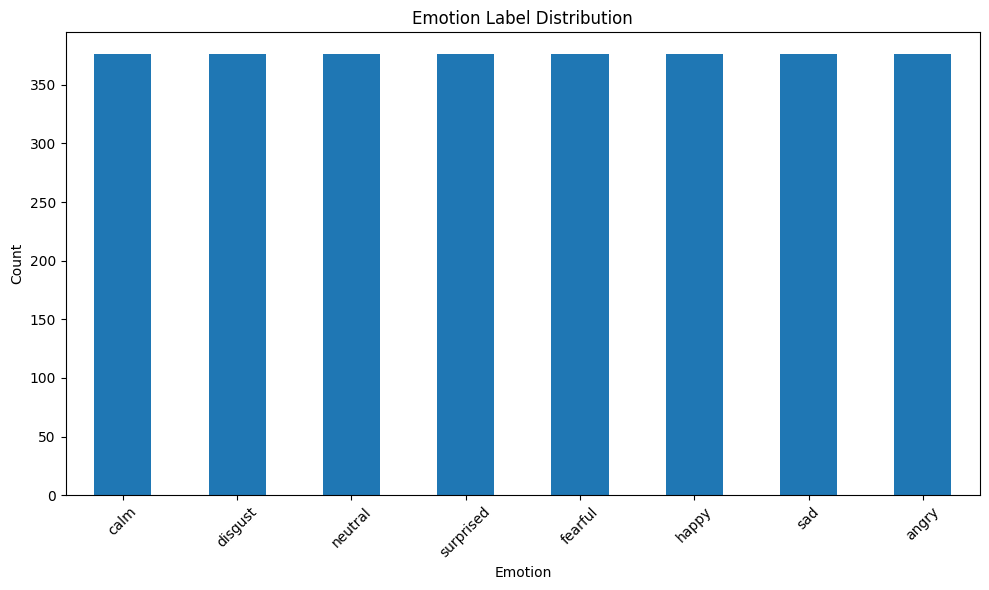


Percentage Distribution:
label
calm         12.5
disgust      12.5
neutral      12.5
surprised    12.5
fearful      12.5
happy        12.5
sad          12.5
angry        12.5
Name: proportion, dtype: float64


In [ ]:

df = pd.read_pickle("processed_audio_features.pkl")

plt.figure(figsize=(10, 6))
df['label'].value_counts().plot(kind='bar')
plt.title('Emotion Label Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nPercentage Distribution:")
print((df['label'].value_counts(normalize=True) * 100).round(2))


####**This confirms our dataset is now ready for fair and unbiased model training.**


## Preparing the Data for Model Training

Now that our dataset is balanced, I needed to **preprocess** it before feeding it into a model.
### Step 1: Feature & Label Separation

I first loaded the balanced dataset and separated it into:
- `X`: a matrix of input features
- `y`: the corresponding emotion labels



###Step 2: Feature Scaling

I am going to scale the features using **StandardScaler**, which transforms each feature to have a mean of 0 and a standard deviation of 1. This helps speed up training and improves performance.



###Step 3: Label Encoding

Since machine learning models require numerical labels, I encode the text labels (e.g., "happy", "sad") into integers using `LabelEncoder`. We then convert the integer labels to **one-hot encoded** vectors using `to_categorical` — this is for training a multi-class classification model with softmax.


###Step 4: Feature Selection

I use **SelectKBest** with ANOVA F-statistic to choose the top 300 most important features , as total features are 860 and taking all features results. This reduces dimensionality and helps the model focus on the most relevant data.

###Step 5: Splitting the Dataset

I split the data into three parts:
- **Train set** (60%)
- **Validation set** (20%) → used to tune hyperparameters and monitor overfitting
- **Test set** (20%) → used only at the end to evaluate final model performance

This ensures that my evaluation is fair and doesn't leak information from training into testing.


In [ ]:
df = pd.read_pickle("processed_audio_features.pkl")

X = np.array(df['features'].tolist())
y = df['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

le = LabelEncoder()
y_encoded = le.fit_transform(y)  # shape: (N,)
num_classes = len(np.unique(y_encoded))
y_categorical = to_categorical(y_encoded)  # shape: (N, num_classes)

selector = SelectKBest(f_classif, k=300)
X_selected = selector.fit_transform(X_scaled, y_encoded)

X_temp, X_test, y_temp, y_test = train_test_split(X_selected, y_categorical, test_size=0.2, stratify=y_encoded, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=np.argmax(y_temp, axis=1), random_state=42)

## Handling Class Imbalance with Class Weights (for Added Robustness)

Although I already balanced the dataset, using **class weights** is a good practice in multi-class classification. This ensures that even slight differences in class distribution don't bias the model toward majority classes.
Class weights tell the model to pay **more attention to underrepresented classes** by giving them a higher penalty in the loss function. I use Scikit-learn’s `compute_class_weight()` function to calculate these weights based on the original label distribution.


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_encoded),
    y=y_encoded
)
class_weights = dict(enumerate(class_weights))


#Defining and Training Model

## 🤖 Building & Training the Deep Learning Model

I designed a **fully connected neural network (ANN)** for multi-class emotion classification.
Below is a brief explanation of its architecture and training logic:


###Model Architecture

- **Input Layer:** Matches the number of selected features (`X_train.shape[1]`)
- **Hidden Layers:**
  - 3 Dense layers with decreasing sizes: 512 → 256 → 112
  - Each layer uses **ReLU** activation and **L2 regularization** to reduce overfitting
  - **Batch Normalization** for faster and stable convergence
  - **Dropout layers** to prevent overfitting by randomly turning off neurons during training

- **Output Layer:**
  - Dense layer with `softmax` activation for multi-class classification (one neuron per emotion)


###Compilation Details

- **Loss Function:** `categorical_crossentropy` (used for multi-class problems)
- **Optimizer:** `Adam` with a learning rate of `0.0005` (tuned to train steadily)
- **Metrics:** `accuracy`



###Callbacks Used

- **EarlyStopping:** Stops training early if validation loss doesn't improve for 20 epochs, and restores best weights
- **ReduceLROnPlateau:** Reduces the learning rate if validation loss plateaus, to help fine-tune learning


###Model Training

- **Epochs:** 200 (but training may stop early due to early stopping)
- **Batch Size:** 128
- **Validation Data:** Used to monitor generalization
- **Class Weights:** Used to further balance the loss impact of each class

This setup ensures both effective learning and robustness against overfitting.


In [ ]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(112, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])
#512, 256, 128 to 768, 384, 192, or 1024, 512, 256

early_stopping = EarlyStopping(
    monitor='val_loss', # or 'val_accuracy'
    patience=20,        # Number of epochs to wait before stopping after no improvement
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=10, # Number of epochs with no improvement after which learning rate will be reduced.
    min_lr=1e-6,
    verbose=1
)

optimizer = Adam(learning_rate=5e-4)  # lower than default (which is 1e-3)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=128, callbacks=[early_stopping, reduce_lr], class_weight=class_weights)

Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.1954 - loss: 3.4017 - val_accuracy: 0.3256 - val_loss: 2.6935 - learning_rate: 5.0000e-04
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4112 - loss: 2.5261 - val_accuracy: 0.4203 - val_loss: 2.5326 - learning_rate: 5.0000e-04
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5045 - loss: 2.2660 - val_accuracy: 0.5083 - val_loss: 2.3953 - learning_rate: 5.0000e-04
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5260 - loss: 2.1594 - val_accuracy: 0.5548 - val_loss: 2.2714 - learning_rate: 5.0000e-04
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5948 - loss: 2.0275 - val_accuracy: 0.5963 - val_loss: 2.1879 - learning_rate: 5.0000e-04
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6192 - loss: 1.9461 - val_accuracy: 0.6213 - val_loss: 2.1014 - learning_rate: 5.0000e-04
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 

##Evaluating Model Performance on Test Set

After training, I evaluate the model using the **test set**, which the model has never seen before. This gives us a real-world estimate of how well our model performs on new data.


###Metrics Computed

- **Test Accuracy:** The overall percentage of correctly predicted samples.
- **Accuracy Plot:** Graph of training vs. validation accuracy over epochs to check for overfitting or underfitting.
- **Classification Report:** Shows precision, recall, and F1-score for each emotion.
- **Confusion Matrix:** Visual matrix showing how often one emotion is misclassified as another.


###Significance of Each Metric

- **Classification report** helps me understand which emotions are being predicted well and which need improvement.
- **Confusion matrix** is very useful in identifying specific misclassifications (e.g., sad mistaken for calm).
- **Validation curve** helps me ensure model generalization — if val_acc stays close to train_acc, model is not overfitting.

This final evaluation helps me **trust the model** before using it in production or deployment.


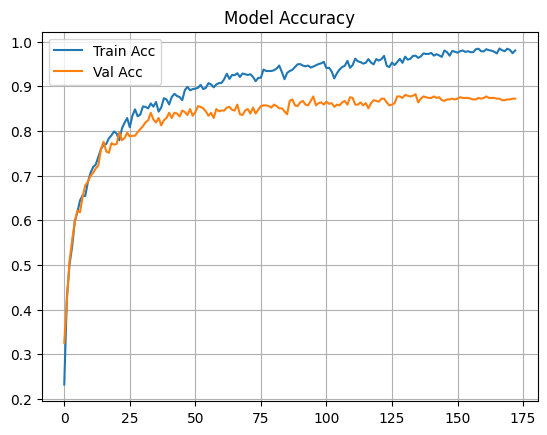


Test Accuracy: 89.87%
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.90      0.85      0.88        75
        calm       0.84      0.96      0.89        75
     disgust       0.93      0.92      0.93        75
     fearful       0.91      0.83      0.87        76
       happy       0.90      0.88      0.89        75
     neutral       0.90      0.97      0.94        75
         sad       0.86      0.82      0.84        76
   surprised       0.95      0.96      0.95        75

    accuracy                           0.90       602
   macro avg       0.90      0.90      0.90       602
weighted avg       0.90      0.90      0.90       602



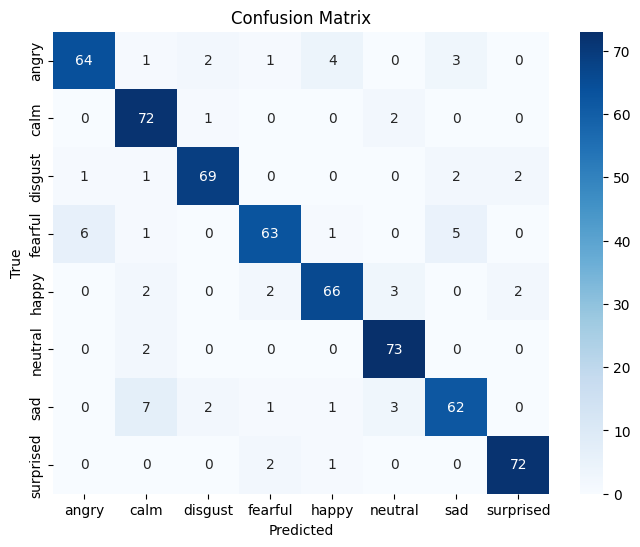

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Model Accuracy")
plt.legend()
plt.grid()
plt.show()


print(f"\nTest Accuracy: {accuracy*100:.2f}%")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import joblib

joblib.dump(scaler, "scaler.pkl")
joblib.dump(le, "label_encoder.pkl")
joblib.dump(selector, "feature_selector.pkl")
model.save("emotion_model.h5")
